In [27]:
import numpy as np
import scipy
from scipy import stats

import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

In [3]:
# Define colors 
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Bayesian modeling notes

These notebooks consist of my notes, codes and solutions to exercises from the book ["Bayesian modeling and computation in Python" (Martin et al., 2022)](https://bayesiancomputationbook.com/welcome.html)


# Exploratory Analysis of Bayesian Models



## Diagnosing numerical inference

Monte Carlo Markov Chains ([**MCMC**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)) diagnosis.

Good **MCMC** chain should ideally resemble an $iid$ sample. 

### Generate fake chains

In [39]:
# Let's simulate good and bad chains
good_chains = stats.beta(2, 5).rvs(size=(2, 2000))


# The first set of bad chains will be autocorrelated and not iid
bad_chains_0 = np.random.normal(
    loc=np.sort(good_chains, axis=None), 
    scale=0.05,
    size=4000).reshape(2, -1)


# The second set of chains will contain strong random autocorrelations
bad_chains_1 = good_chains.copy()

for i in np.random.randint(1900, size=4):
    bad_chains_1[i%2:, i : i+100] = np.random.beta(i, 950, size=100)

    
# Create chains object 
chains = {
    'good_chains': good_chains,
    'bad_chains_0': bad_chains_0,
    'bad_chains_1': bad_chains_1
}

### Diagnose the chains - $ESS$

#### Effective Sample Size (ESS)

[**Effective sample size**](https://en.wikipedia.org/wiki/Effective_sample_size) helps us understand is a given MCMC chain is large enough to let us compute quantities of interest.

**ESS** will be smaller for **autocorrelated** samples, comparing to non-autocorrelated samples of the same size. In this sense **ESS** is related to informatrion content and entropy.

In [40]:
az.ess(chains)

<xarray.Dataset>
Dimensions:       ()
Data variables:
    good_chains   float64 3.685e+03
    bad_chains_0  float64 2.435
    bad_chains_1  float64 140.8

We can see that `bad_chains_0` has a very small $ESS$. It's due to high autocorrelation of the samples.

Similarily, $ESS$ of `bad_chains_1` is relatively very low, comparing to `good_chains`.

$ESS$ for `good_chains`, that are $iid$, is very close to the actual sample size $n=4000$.

___________________

**NOTE**: for a good sample it's possible that $ESS > n$ under certain conditions.

______________________________



$ESS$ can be also computed for any quantile:

In [59]:
az.ess(chains, method='quantile', prob=.05)

<xarray.Dataset>
Dimensions:       ()
Data variables:
    good_chains   float64 3.909e+03
    bad_chains_0  float64 11.45
    bad_chains_1  float64 3.532e+03

Let's visualize $ESS$:

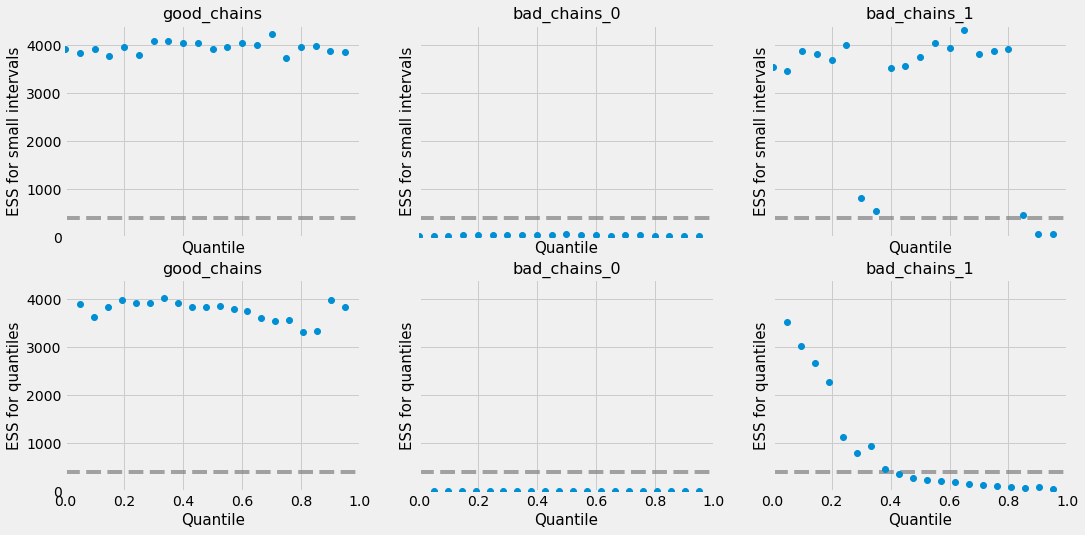

In [51]:
# Get axes
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))

# Plot ESS plots
az.plot_ess(chains, kind='local', ax=axes[0])
az.plot_ess(chains, kind='quantile', ax=axes[1])

plt.show()

### Diagnose the chains - $\hat{R}$

$\hat{R}$ aka **potential scale reduction factor** helps us understand if our MCMC samples converged. 

It compares variance within chains to variance between chains.

Values that are

$$\large \hat{R} \lessapprox 1.01$$

are considered safe as a rule of thumb.

____________

Let's check our samples:

In [60]:
az.rhat(chains)

<xarray.Dataset>
Dimensions:       ()
Data variables:
    good_chains   float64 1.001
    bad_chains_0  float64 2.411
    bad_chains_1  float64 1.026

### Diagnose the chains - $MCSE$


$MCSE$ stands for Monte Carlo Standard Error. It informs us about the precision of estimates. 

Martin et al. (2022) say that:

*If we want to report the value of an estimated parameter to the second decimal, we need to be sure that $MCSE$ is below the second decimal, otherwise, we'll be, wrongly, reporting a higher precision than we really have* (p. 43)

This quantity should be checked iff $ESS$ and $\hat{R}$ are ok, otherwise $MCSE$ is meaningless.

In [61]:
az.mcse(chains)

<xarray.Dataset>
Dimensions:       ()
Data variables:
    good_chains   float64 0.002654
    bad_chains_0  float64 0.1081
    bad_chains_1  float64 0.01731

We can also check the value of $MCSE$ for quantiles:

In [108]:
?az.plot_mcse

In [119]:
ax[0].set_ylim

<bound method _AxesBase.set_ylim of <AxesSubplot:>>

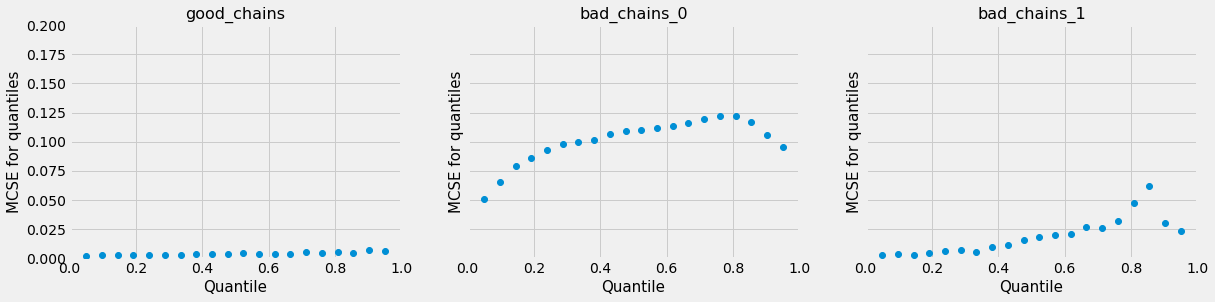

In [122]:
_, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for a in ax:
    a.set_ylim(0, .2)
    
az.plot_mcse(chains, ax=ax)
plt.show()

Note that `good_chains` values are much lower than other values.

### Diagnose the chains - $ESS$, $\hat{R}$, $MCSE$

In [83]:
az.summary(chains, kind='diagnostics')

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
good_chains,0.003,0.002,3685.0,3843.0,1.00
bad_chains_0,0.108,0.088,2.0,11.0,2.41
bad_chains_1,0.017,0.014,141.0,56.0,1.03


In [84]:
# Add even more info:
az.summary(chains)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
good_chains,0.285,0.160,0.029,0.581,0.003,0.002,3685.0,3843.0,1.00
bad_chains_0,0.285,0.167,0.003,0.591,0.108,0.088,2.0,11.0,2.41
bad_chains_1,0.313,0.180,0.055,0.660,0.017,0.014,141.0,56.0,1.03


### Diagnose the chains - Trace plots

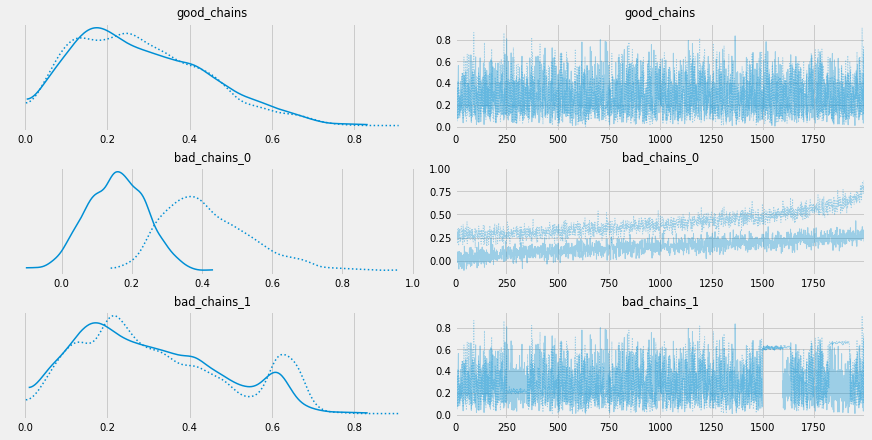

In [102]:
az.plot_trace(chains, plot_kwargs={'lw': 1.5}, trace_kwargs={'lw': 1})
plt.show()

On the left, we see $KDE$s for two chains. We can see that for `good_chains` both distributions are virtually identical. `bad_chain_1` has only slight differences in distributions and therefore might be a bit tricky to distinguish from a good set of chains. 

On the right, we see traces. Looking at `bad_chains_1` trace, we see the problem more clearly here.

### Diagnose the chains - Autocorrelation

Autocorrelation decreases amount of information in chains (and therefore decreases $ESS$). 

Let's plot it:

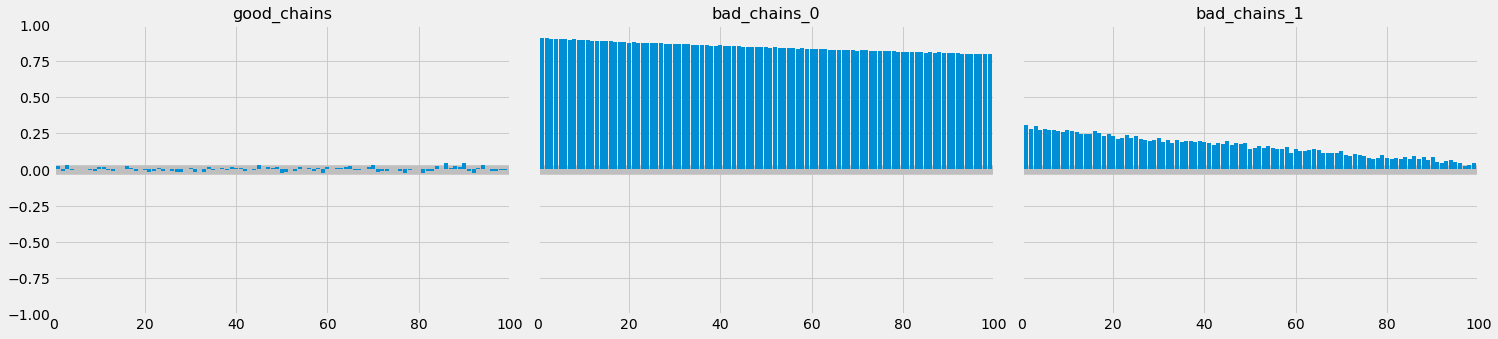

In [105]:
az.plot_autocorr(chains, combined=True)
plt.show()

### Diagnose the chains - Rank plots

Values are ranked for concatenated chains and then split again. 

Uniform distributions indicate that all chains are targeting the same distribution. 

The dashed line indicates a uniform distribution (perfect scenario).

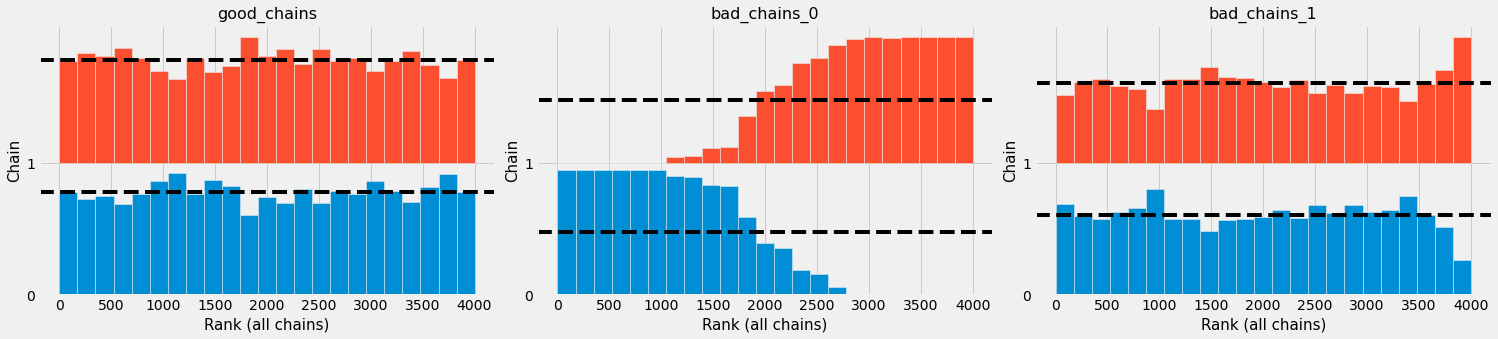

In [124]:
az.plot_rank(chains)
plt.show()

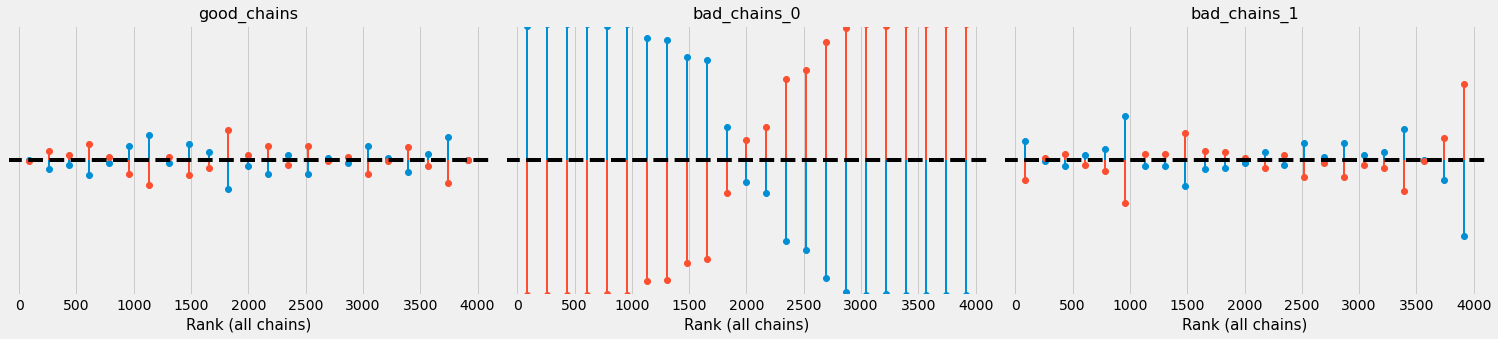

In [125]:
az.plot_rank(chains, kind='vlines')
plt.show()

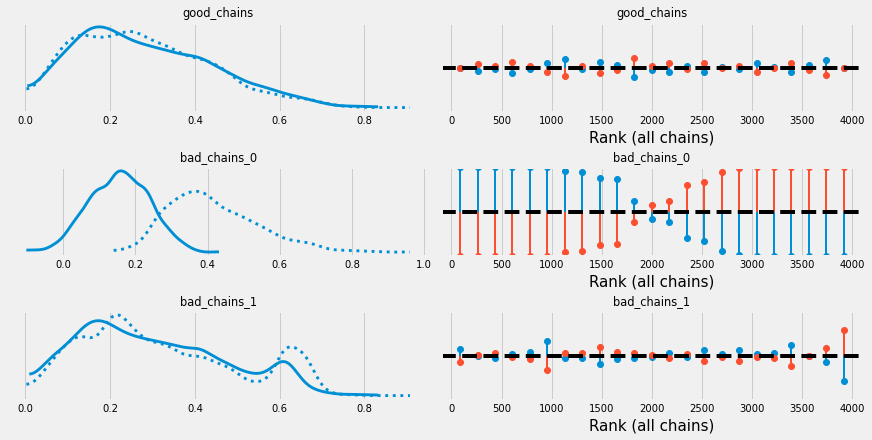

In [130]:
az.plot_trace(chains, kind='rank_vlines')
plt.show()